In [1]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import itertools

from ms_entropy.file_io.msp_file import read_one_spectrum
import numba as nb
import pyteomics.mgf
import sys
import importlib

sys.path.append("../../src/ms_similarity_metrics/")
from create_spectrum import smile2inchi
importlib.reload(sys.modules['create_spectrum'])
from create_spectrum import smile2inchi


# Get queries

In [3]:
# Get the NIST23 queries
queries = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/modified_cosine_queries/query_no_ppm.csv', index_col=0)
weighted_queries = pd.read_csv('s3://enveda-data-user/chloe.engler/cosine_similarity/modified_cosine_queries/weighted_query_no_ppm.csv', index_col=0)
# queries = pd.read_csv('../../data/mod_cosine_queries/modified_cosine_query_3.csv', index_col=0)
# weighted_queries = pd.read_csv('../../data/mod_cosine_queries/weighted_modified_cosine_query.csv', index_col=0)

# Filter the queries to only include queries in both the weighted and unweighted queries
queries = queries[queries['wout_identifier'].isin(weighted_queries['wout_identifier'])]
weighted_queries = weighted_queries[weighted_queries['wout_identifier'].isin(queries['wout_identifier'])]

In [4]:
# Reformat the library_spectra_matches column to a list of tuples
for query in tqdm(queries.index.values):
    matches = []
    non_decimal = re.compile(r'[^\d.]+')

    test = queries.loc[query]['library_spectra_matches'].replace("'", "").replace(')', '').split('(')[1:]
    for pair in test:
        matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))
    queries.loc[query, 'library_spectra_matches'] = matches

#Reformat the library_spectra_matches column to a list of tuples for the weighted queries
for query in tqdm(weighted_queries.index.values):
    matches = []
    non_decimal = re.compile(r'[^\d.]+')

    test = weighted_queries.loc[query]['library_spectra_matches'].replace("'", "").replace(')', '').split('(')[1:]
    for pair in test:
        matches.append((pair.split(',')[0], float(non_decimal.sub('', pair.split(',')[1]))))
    weighted_queries.loc[query, 'library_spectra_matches'] = matches


100%|██████████| 29985/29985 [01:14<00:00, 402.84it/s] 


# Get NIST23 data

In [5]:
# Get NIST23 library
# Get data from s3://enveda-data-user/chloe.engler/cosine_similarity/NIST_data/NIST23-HR-MSMS.MSP
spectra_list = []
for i,spectrum in tqdm(enumerate(read_one_spectrum('../../data/NIST23-HR-MSMS.MSP'))):
    spectra_list.append(spectrum)

1934658it [03:33, 9079.24it/s] 


In [6]:
# Create NIST dataframe
nist_df = pd.DataFrame(spectra_list)
nist_df = nist_df[nist_df['precursor_type'] == '[M+H]+' ]

# Get Wout data

In [7]:
# Profile spectra contain 0 intensity values.
@nb.njit
def is_centroid(intensity_array):
    return np.all(intensity_array > 0)

In [8]:
# Read all spectra from the MGF.
spectra = []

# Download from https://zenodo.org/record/6829249/files/ALL_GNPS_NO_PROPOGATED.mgf?download=1
filename = ("../../data/ALL_GNPS_NO_PROPOGATED.mgf")

# Get wout spectra
with pyteomics.mgf.MGF(filename) as f_in:
    for spectrum_dict in tqdm(f_in):
        spectra.append(spectrum_dict)

495600it [02:11, 3781.19it/s] 


In [9]:
# Create wout dataframe
wout_df = pd.DataFrame(spectra)
wout_df = pd.concat([wout_df.drop(['params'], axis=1), wout_df['params'].apply(pd.Series)], axis=1)
wout_df.head(2)

,m/z array,intensity array,charge array,pepmass,charge,mslevel,source_instrument,filename,seq,ionmode,...,pi,datacollector,smiles,inchi,inchiaux,pubmed,submituser,libraryquality,spectrumid,scans
0,"[289.286377, 295.545288, 298.489624, 317.32495...","[8068.0, 22507.0, 3925.0, 18742.0, 8604.0, 804...","[--, --, --, --, --, --, --, --, --, --, --, -...","(981.54, None)",[0+],2,LC-ESI-qTof,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,*..*,Positive,...,Gerwick,Jenia,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,N/A,N/A,N/A,mwang87,1,CCMSLIB00000001547,1
1,"[278.049927, 278.957642, 281.258667, 291.99609...","[35793.0, 47593.0, 95495.0, 115278.0, 91752.0,...","[--, --, --, --, --, --, --, --, --, --, --, -...","(940.25, None)",[0+],2,LC-ESI-qTof,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,*..*,Positive,...,Gerwick,Amanda,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...,N/A,N/A,mwang87,1,CCMSLIB00000001548,1


In [10]:
# Get wout metadata
metadata = pd.read_csv(
    'https://zenodo.org/record/6829249/files/gnps_libraries_metadata.csv?download=1'
)
metadata.set_index('id', inplace=True)

# Get library for each query spectra

In [11]:
# Remove any query spectra that came from the NIST library
queries['wout_library'] = list(metadata.loc[queries['wout_identifier'],'library'])
queries = queries[queries['wout_library'] != 'GNPS-NIST14-MATCHES']
weighted_queries['wout_library'] = list(metadata.loc[weighted_queries['wout_identifier'],'library'])
weighted_queries = weighted_queries[weighted_queries['wout_library'] != 'GNPS-NIST14-MATCHES']

# Get smiles

In [12]:
# Get nist smiles dict
nist_smiles_dict = {}
for index in tqdm(nist_df.index.values):
    nist_smiles_dict[index] = nist_df.loc[index,'smiles']

# Get wout smiles dict
wout_smiles_dict = {}
for index in tqdm(wout_df.index.values):
    current_id = wout_df.loc[index, 'spectrumid']
    wout_smiles_dict[current_id] = wout_df.loc[index,'smiles']

100%|██████████| 495600/495600 [00:07<00:00, 68056.15it/s]


In [13]:
# Get wout smiles for unweighted queries
for i in tqdm(queries.index.values):
    wout_id = queries.loc[i, 'wout_identifier']
    queries.loc[i, 'wout_smiles'] = wout_smiles_dict[wout_id]

# Get wout smiles for weighted queries
for i in tqdm(queries.index.values):
    wout_id = queries.loc[i, 'wout_identifier']
    weighted_queries.loc[i, 'wout_smiles'] = wout_smiles_dict[wout_id]

100%|██████████| 27430/27430 [00:01<00:00, 17655.00it/s]


# Look at number of matches

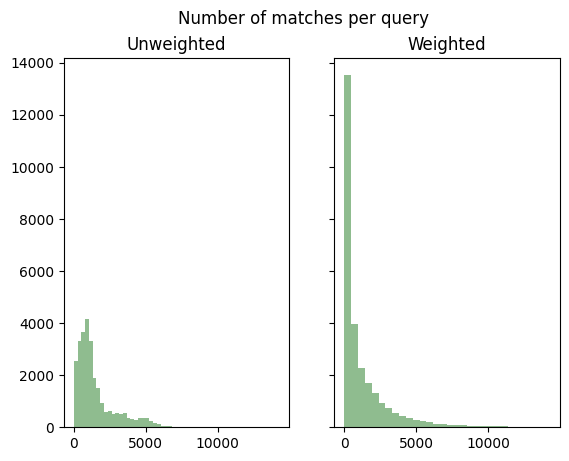

Number of queries with no matches: 247
Number of weighted queries with no matches: 434


In [14]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

# Plot number of matches per query
num_matches = queries.library_spectra_matches.apply(lambda x: len(x))
ax1.hist(num_matches, bins=30, color='darkseagreen')
ax1.set_title('Unweighted')

# Plot number of matches per weighted query
num_weighted_matches = weighted_queries.library_spectra_matches.apply(lambda x: len(x))
ax2.hist(num_weighted_matches, bins=30, color='darkseagreen')
ax2.set_title('Weighted')

# Show plot
plt.suptitle('Number of matches per query')
plt.show()

print('Number of queries with no matches: {}'.format(len(num_matches[num_matches == 0])))
print('Number of weighted queries with no matches: {}'.format(len(num_weighted_matches[num_weighted_matches == 0])))

# Get inchikeys

In [15]:
# Get NIST23 partial inchikeys
inchi_dict = {}
for i in tqdm(queries.index.values):
    inchi_list = []
    for pair in queries.loc[i, 'library_spectra_matches']:
        index = int(pair[0].split('_')[0])
        inchi_list.append(nist_df.loc[int(pair[0].split('_')[0]),'inchikey'][:14])
    inchi_dict[i] = inchi_list
queries['nist_inchis'] = queries.index.map(inchi_dict)

# Get NIST23 partial inchikeys
weighted_inchi_dict = {}
for i in tqdm(weighted_queries.index.values):
    inchi_list = []
    for pair in weighted_queries.loc[i, 'library_spectra_matches']:
        index = int(pair[0].split('_')[0])
        inchi_list.append(nist_df.loc[int(pair[0].split('_')[0]),'inchikey'][:14])
    weighted_inchi_dict[i] = inchi_list
weighted_queries['nist_inchis'] = queries.index.map(weighted_inchi_dict)

100%|██████████| 27430/27430 [04:55<00:00, 92.91it/s] 


In [16]:
# Get wout partial inchikeys for queries
for i in tqdm(queries.index.values):
    inchi = smile2inchi(queries.loc[i, 'wout_smiles'])
    queries.loc[i, 'wout_inchi'] = inchi[:14]

# Get wout partial inchikeys for weighted queries
for i in tqdm(weighted_queries.index.values):
    inchi = smile2inchi(weighted_queries.loc[i, 'wout_smiles'])
    weighted_queries.loc[i, 'wout_inchi'] = inchi[:14]

  0%|          | 0/27430 [00:00<?, ?it/s]

100%|██████████| 27430/27430 [00:19<00:00, 1427.36it/s]


# Look at exact matches

### Look at ranks of exact matches

In [17]:
# Get indexes of exact matches for queries
all_matches = {}
for i in tqdm(queries.index.values):
    exact_matches = np.where(np.array(list(queries.loc[i, 'nist_inchis'])) == queries.loc[i, 'wout_inchi'])[0]
    all_matches[i] = exact_matches
queries['exact_matches'] = queries.index.map(all_matches)

# Get indexes of exact matches for weighted queries
all_matches_weighted = {}
for i in tqdm(weighted_queries.index.values):
    exact_matches = np.where(np.array(list(weighted_queries.loc[i, 'nist_inchis'])) == weighted_queries.loc[i, 'wout_inchi'])[0]
    all_matches_weighted[i] = exact_matches
weighted_queries['exact_matches'] = queries.index.map(all_matches_weighted)




  0%|          | 0/27430 [00:00<?, ?it/s]/tmp/ipykernel_337627/3679891818.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  exact_matches = np.where(np.array(list(queries.loc[i, 'nist_inchis'])) == queries.loc[i, 'wout_inchi'])[0]
  0%|          | 0/27430 [00:00<?, ?it/s]/tmp/ipykernel_337627/3679891818.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  exact_matches = np.where(np.array(list(weighted_queries.loc[i, 'nist_inchis'])) == weighted_queries.loc[i, 'wout_inchi'])[0]
100%|██████████| 27430/27430 [00:04<00:00, 5588.85it/s]


In [19]:
# Get all ranks of exact matches
all_ranks = list(itertools.chain(*list(queries['exact_matches'])))
all_ranks_weighted = list(itertools.chain(*list(weighted_queries['exact_matches'])))

# Get highest rank of exact matches for each query
all_rank_1 = [x[0] for x in queries['exact_matches'] if len(x) > 0]
all_rank_1_weighted = [x[0] for x in weighted_queries['exact_matches'] if len(x) > 0]

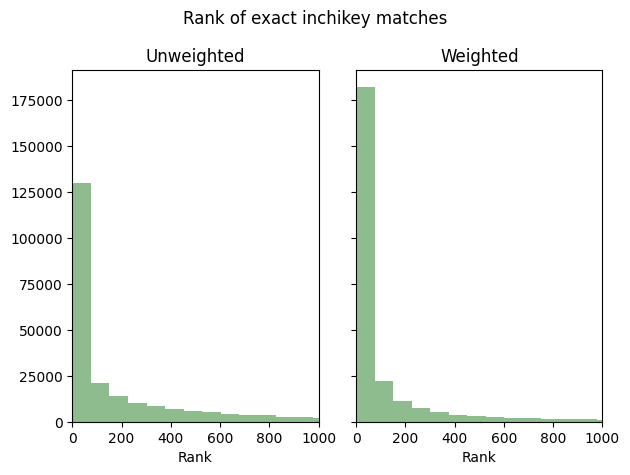

Median unweighted rank:  57.0
Median weighted rank:  20.0


In [20]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

# Plot rank of exact matches
_,bins,_ = ax1.hist(all_ranks, bins=100, color='darkseagreen')
ax1.set_title('Unweighted')
ax1.set_xlim(0,1000)
ax1.set_xlabel('Rank')

# Plot rank of exact matches for weighted queries
ax2.hist(all_ranks_weighted, bins=bins, color='darkseagreen')
ax2.set_title('Weighted')
ax2.set_xlabel('Rank')
ax2.set_xlim(0,1000)

# Show plot
plt.suptitle('Rank of exact inchikey matches')
plt.tight_layout()
#plt.savefig('../figures/rank_modified_cosine.png', dpi=400)
plt.show()

print('Median unweighted rank: ', np.median(all_ranks))
print('Median weighted rank: ', np.median(all_ranks_weighted))

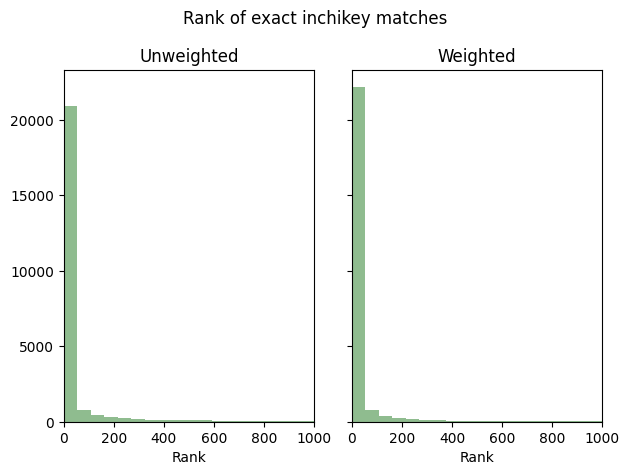

Median unweighted top rank:  0.0
Median weighted top rank:  0.0


In [21]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

# Plot highest rank of exact matches
_,bins,_ = ax1.hist(all_rank_1, bins=100, color='darkseagreen')
ax1.set_title('Unweighted')
ax1.set_xlim(0,1000)
ax1.set_xlabel('Rank')

# Plot highest rank of exact matches for weighted queries
ax2.hist(all_rank_1_weighted, bins=bins, color='darkseagreen')
ax2.set_title('Weighted')
ax2.set_xlabel('Rank')
ax2.set_xlim(0,1000)

# Show plot
plt.suptitle('Rank of exact inchikey matches')
plt.tight_layout()
plt.show()

print('Median unweighted top rank: ', np.median(all_rank_1))
print('Median weighted top rank: ', np.median(all_rank_1_weighted))

#### Look at the percent of queries with an exact match in the top n matches

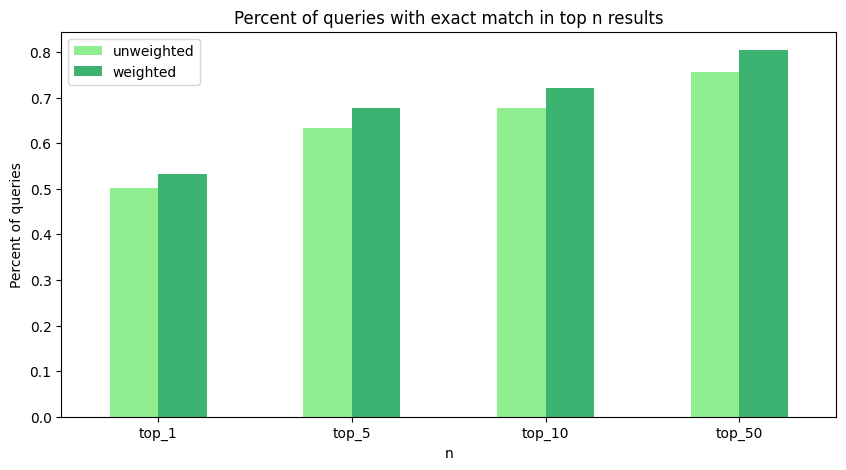

In [25]:
# Create data frame
exact_matches_top_n = pd.DataFrame(columns=['unweighted', 'weighted'], 
                                   index=['top_1', 'top_5', 'top_10', 'top_50'])
n_vals = [1, 5, 10, 50]

# Get percent of queries with exact match in top 5
for n in n_vals:
    exact_matches_top_n.loc[f'top_{n}', 'unweighted'] = queries.loc[queries['exact_matches'].apply(lambda x: min(x) \
                                                        if len(x) > 0 else np.nan)<n].shape[0] / queries.shape[0]
    exact_matches_top_n.loc[f'top_{n}', 'weighted'] =  weighted_queries.loc[weighted_queries['exact_matches'].apply(lambda x: min(x) \
                                                        if len(x) > 0 else np.nan)<n].shape[0] / weighted_queries.shape[0]

# Create bar plot
exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['lightgreen', 'mediumseagreen', 'darkgreen'])
plt.title('Percent of queries with exact match in top n results')
plt.ylabel('Percent of queries')
plt.xlabel('n')
plt.show()

### Look at similarity scores for exact matches

In [23]:
# Get similarity scores for exact matches in queries
exact_match_similarities = []
for i in tqdm(queries.index.values):
    current_matches = queries.loc[i, 'exact_matches']
    if len(current_matches) != 0:
        exact_match_similarities += list(np.array(queries.loc[i, 'library_spectra_matches'])[current_matches][:,1].astype(float))

# Get similarity scores for exact matches in queries
weighted_exact_match_similarities = []
for i in tqdm(weighted_queries.index.values):
    current_matches = weighted_queries.loc[i, 'exact_matches']
    if len(current_matches) != 0:
        weighted_exact_match_similarities += list(np.array(weighted_queries.loc[i, 'library_spectra_matches'])[current_matches][:,1].astype(float))

100%|██████████| 27430/27430 [00:37<00:00, 739.85it/s] 


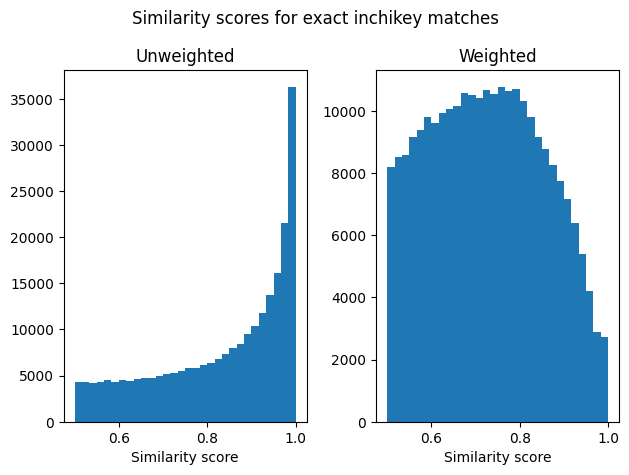

In [27]:
# Plot similarity scores for exact matches
plt.subplot(1,2,1)
plt.hist(exact_match_similarities, bins=30)
plt.suptitle('Similarity scores for exact inchikey matches')
plt.title('Unweighted')
plt.xlabel('Similarity score')

# Plot similarity scores for exact matches from weighted queries
plt.subplot(1,2,2)
plt.hist(weighted_exact_match_similarities, bins=30)
plt.title('Weighted')
plt.xlabel('Similarity score')
plt.tight_layout()
plt.show()

### Look at the percentage of exact inchikey pairs with similarity above 0.5

In [28]:
# Get percent exact inchikey pairs with similarity above 0.5
nist_df['partial_inchikey'] = nist_df['inchikey'].str[:14]
for i in tqdm(queries.index.values):
    queries.loc[i, 'num_inchi_matches'] = len(nist_df[nist_df['partial_inchikey'] == queries.loc[i, 'wout_inchi']])
    queries.loc[i, 'percent_exact'] = len(queries.loc[i, 'exact_matches'])/queries.loc[i, 'num_inchi_matches']

# Get percent exact inchikey pairs with similarity above 0.5 for weighted queries
nist_df['partial_inchikey'] = nist_df['inchikey'].str[:14]
for i in tqdm(weighted_queries.index.values):
    weighted_queries.loc[i, 'num_inchi_matches'] = len(nist_df[nist_df['partial_inchikey'] == weighted_queries.loc[i, 'wout_inchi']])
    weighted_queries.loc[i, 'percent_exact'] = len(weighted_queries.loc[i, 'exact_matches'])/weighted_queries.loc[i, 'num_inchi_matches']

100%|██████████| 27430/27430 [14:04<00:00, 32.48it/s]


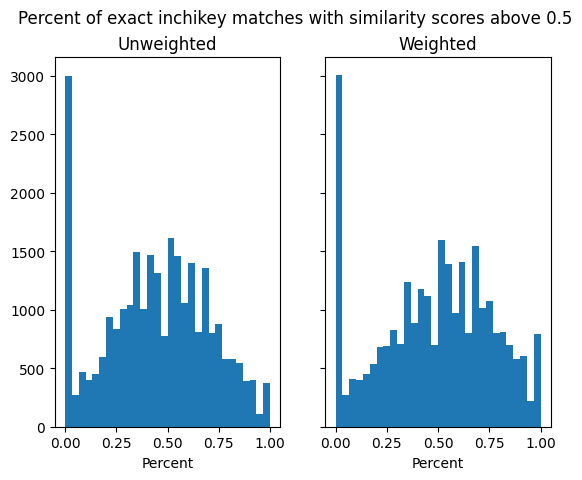

Median percent exact matches for unweighted:  0.45161290322580644
Median percent exact matches for weighted:  0.5


In [29]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1,2, sharey=True)

# Plot percent of exact inchikey matches with similarity scores above 0.5
ax1.hist(queries['percent_exact'], bins=30)
ax1.set_title('Unweighted')
ax1.set_xlabel('Percent')

# Plot percent of exact inchikey matches with similarity scores above 0.5 for weighted queries
ax2.hist(weighted_queries['percent_exact'], bins=30)
ax2.set_title('Weighted')
ax2.set_xlabel('Percent')

# Show plot
plt.suptitle('Percent of exact inchikey matches with similarity scores above 0.5')
plt.show()

print('Median percent exact matches for unweighted: ', np.median(queries['percent_exact']))
print('Median percent exact matches for weighted: ', np.median(weighted_queries['percent_exact']))

# Look at AUC scores

In [31]:
from sklearn.metrics import roc_curve, auc

no_matches = 0

# Get AUC scores for queries
for index in tqdm(queries.index.values):
    if len(np.array(list(queries.loc[index,'library_spectra_matches']))) != 0:
        prob = np.array(list(queries.loc[index,'library_spectra_matches']))[:,1].astype('float')
        y_true = np.zeros(len(prob))
        y_true[queries.loc[index,f'exact_matches']] = 1

        # check if there arent any 1.0s in y_true
        if np.sum(y_true) == 0:
            queries.loc[index, f'auc'] = 0
        # check if all values are 1.0
        elif np.sum(y_true) == len(y_true):
            queries.loc[index, f'auc'] = 1
        else:
            fpr, tpr, thresholds = roc_curve(y_true, prob)
            queries.loc[index, f'auc'] = auc(fpr, tpr)
    else:
        no_matches += 1
        queries.loc[index, f'auc'] = np.nan

# Get AUC scores for weighted queries
for index in tqdm(weighted_queries.index.values):
    if len(np.array(list(weighted_queries.loc[index,'library_spectra_matches']))) != 0:
        prob = np.array(list(weighted_queries.loc[index,'library_spectra_matches']))[:,1].astype('float')
        y_true = np.zeros(len(prob))
        y_true[weighted_queries.loc[index,f'exact_matches']] = 1

        # check if there arent any 1.0s in y_true
        if np.sum(y_true) == 0:
            weighted_queries.loc[index, f'auc'] = 0
        # check if all values are 1.0
        elif np.sum(y_true) == len(y_true):
            weighted_queries.loc[index, f'auc'] = 1
        else:
            fpr, tpr, thresholds = roc_curve(y_true, prob)
            weighted_queries.loc[index, f'auc'] = auc(fpr, tpr)
    else:
        weighted_queries.loc[index, f'auc'] = np.nan

100%|██████████| 27430/27430 [02:01<00:00, 226.02it/s]


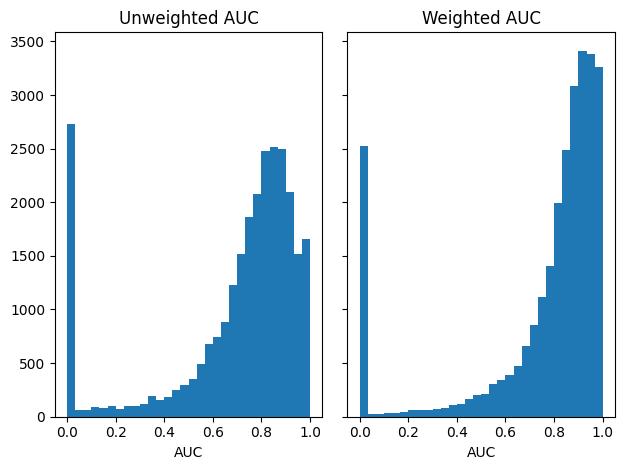

In [32]:
# Set initial variables
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot AUC scores for queries
ax1.hist(queries[f'auc'], bins=30)
ax1.set_title(f'Unweighted AUC')
ax1.set_xlabel('AUC')

# Plot AUC scores for weighted queries
ax2.hist(weighted_queries[f'auc'], bins=30)
ax2.set_title(f'Weighted AUC')
ax2.set_xlabel('AUC')

# Show plot
plt.tight_layout()
plt.show()